<a href="https://colab.research.google.com/github/Itsuki-Hamano123/auto_ml/blob/master/tool_comparison/radon_dataset/autokeras_regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install -q git+https://github.com/keras-team/keras-tuner.git@1.0.2rc3
%pip install -q autokeras
%pip show keras-tuner autokeras scikit-learn

     |████████████████████████████████| 143kB 25.8MB/s 
     |████████████████████████████████| 849kB 32.1MB/s 
     |████████████████████████████████| 36.7MB 83kB/s 
     |████████████████████████████████| 358kB 59.6MB/s 
     |████████████████████████████████| 1.1MB 51.2MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 
     |████████████████████████████████| 174kB 60.9MB/s 
Name: keras-tuner
Version: 1.0.2rc3
Summary: Hypertuner for Keras
Home-page: https://github.com/keras-team/keras-tuner
Author: The Keras Tuner authors
Author-email: kerastuner@google.com
License: Apache License 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: terminaltables, tqdm, tabulate, packaging, scipy, numpy, scikit-learn, future, requests, colorama
Required-by: 
---
Name: autokeras
Version: 1.0.10
Summary: AutoML for deep learning
Home-page: http://autokeras.com
Author: Data Analytics at Texas A&M (DATA) Lab, Keras Team
Author-email: jhfjhfj1@gmail.com
License: MIT
Location: /usr/l

In [2]:
import datetime
import os
import pprint

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
from sklearn.preprocessing import MultiLabelBinarizer
from autokeras import StructuredDataRegressor
import tensorflow_datasets as tfds
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

## データセット読み込み
- radonデータセット[https://www.tensorflow.org/datasets/catalog/radon](https://www.tensorflow.org/datasets/catalog/radon)

In [3]:
def fetch_tf_dataset(data_name, 
                     split='train',
                     shuffle_files=True, as_supervised=True,
                     with_info=True, batch_size=None):
  '''TensorFlowデータセットからデータをフェッチ'''
  dataset, data_info = tfds.load(data_name, split=split,
                                  shuffle_files=shuffle_files,
                                  as_supervised=as_supervised,
                                  with_info=with_info,
                                  batch_size=batch_size)
  return dataset, data_info
  


data_name = 'radon' # @param{type:'string'}
x_name = 'features' # @param{type:'string'}
y_name = 'activity' # @param{type:'string'}
# インメモリでデータを読み込む
batch_size = -1

# データのフェッチ
tf_dataset, ds_info = fetch_tf_dataset(data_name=data_name,
                                     as_supervised=False,
                                     batch_size=batch_size)

display(ds_info)

Shuffling and writing examples to /root/tensorflow_datasets/radon/1.0.0.incomplete4I8KIE/radon-train.tfrecord


Dataset radon downloaded and prepared to /root/tensorflow_datasets/radon/1.0.0. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='radon',
    version=1.0.0,
    description='Radon is a radioactive gas that enters homes through contact
points with the ground. It is a carcinogen that is the primary cause of lung
cancer in non-smokers. Radon levels vary greatly from household to household.
This dataset contains measured radon levels in U.S homes by county and state.
The 'activity' label is the measured radon concentration in pCi/L. Important
predictors are 'floor' (the floor of the house in which the measurement was
taken), 'county' (the U.S. county in which the house is located), and 'Uppm' (a
measurement of uranium level of the soil by county).',
    homepage='http://www.stat.columbia.edu/~gelman/arm/examples/radon/',
    features=FeaturesDict({
        'activity': tf.float32,
        'features': FeaturesDict({
            'Uppm': tf.float32,
            'adjwt': tf.float32,
            'basement': tf.string,
            'cntyfips': tf.int32,
            'county': tf.string,
      

### Dataframeに変換

In [4]:
%%time

def convert_tfds_to_df(tf_ds, x_key, y_key):
  '''tf DatasetをDataframeに変換'''
  
  # yについて{key:numpy}形式のdictに変換
  y = {}
  y[y_key] = tf_ds[y_key].numpy()

  # xについて[{key:numpy},{key:numpy},,,]形式のdictに変換
  x = {}
  for f_key, element in tf_ds[x_key].items():
    if element.dtype == 'string':
      x[f_key] = _convert_byte_np_to_string_np(bytes_np=element.numpy())
    else:
      x[f_key] = element.numpy()
  
  y_df = pd.DataFrame.from_dict(y)
  x_df = pd.DataFrame.from_dict(x)
  df = pd.concat([y_df, x_df], axis=1)

  return df


def _convert_byte_np_to_string_np(bytes_np, decode_char='utf-8'):
  '''バイナリ文字列形式のnumpy配列を文字列形式のnumpy配列に変換'''
  decode_np = np.array([])
  for b in bytes_np:
    decode_np = np.append(decode_np, b.decode(decode_char))
  decode_np = decode_np.astype('unicode')
  return decode_np



# tf datasetからDataframeに変換
dataset = convert_tfds_to_df(tf_dataset, x_key=x_name, y_key=y_name)


display(dataset.head())
display(dataset.shape)


# カラム名の設定
y_col = y_name
x_cols = dataset.drop(columns=y_col).columns

display('y_col:{}'.format(y_col))
display('x_cols num:{}, names:{}'.format(len(x_cols), x_cols))

,activity,Uppm,adjwt,basement,cntyfips,county,dupflag,floor,idnum,lat,lon,pcterr,region,rep,room,startdt,starttm,state,state2,stfips,stopdt,stoptm,stratum,typebldg,wave,windoor,zip,zipflag
0,1.6,2.49759,292.219543,N,3,ALLEN,0,1,1681,41.091000,-85.067001,12.7,2,3,2,11489,2230,IN,IN,18,11689,2235,2,1,92,,46835,0
1,0.5,2.66527,364.958313,N,25,YAVAPAI,0,1,1457,34.599998,-112.554001,0.0,2,5,2,22688,833,AZ,AZ,4,22888,1010,2,1,56,,86325,0
2,3.0,2.43343,626.564575,Y,17,MIDDLESEX,0,0,4224,42.485001,-71.391998,9.7,6,1,2,32288,1000,MA,MA,25,32488,1000,1,1,23,,1778,0
3,0.6,2.43343,570.611755,N,17,MIDDLESEX,0,1,4094,42.485001,-71.391998,27.6,6,3,3,32488,700,MA,MA,25,32688,1200,1,1,62,,1432,0
4,1.2,2.10811,426.798859,Y,95,JACKSON,0,0,6849,39.007999,-94.347000,23.5,1,3,4,32288,605,MO,MO,29,32488,610,2,1,91,,64134,0


(12573, 28)

'y_col:activity'

"x_cols num:27, names:Index(['Uppm', 'adjwt', 'basement', 'cntyfips', 'county', 'dupflag', 'floor',\n       'idnum', 'lat', 'lon', 'pcterr', 'region', 'rep', 'room', 'startdt',\n       'starttm', 'state', 'state2', 'stfips', 'stopdt', 'stoptm', 'stratum',\n       'typebldg', 'wave', 'windoor', 'zip', 'zipflag'],\n      dtype='object')"

CPU times: user 8.8 s, sys: 257 ms, total: 9.06 s
Wall time: 9.07 s


## データ分割

In [5]:
SEED = 7 #@param{type:'number'}

X_train, X_test, y_train, y_test = train_test_split(dataset[x_cols], dataset[y_col],
                                                    test_size=0.2, random_state=SEED)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train,
                                                  test_size=0.2, random_state=SEED)
display(X_train.shape, y_train.shape)
display(X_val.shape, y_val.shape)
display(X_test.shape, y_test.shape)

(8046, 27)

(8046,)

(2012, 27)

(2012,)

(2515, 27)

(2515,)

## 回帰モデル作成

In [6]:
# 探索アルゴリズムの試行回数
MAX_TRIALS =  2#@param{type:'number'}

regressor = StructuredDataRegressor(overwrite=True,
                                    max_trials=MAX_TRIALS,
                                    seed=SEED)
display(regressor)


# 各モデルのepoch数
EPOCH =  10#@param{type:'number'}

# 早期停止コールバックの定義
es = EarlyStopping(monitor='val_loss',
                   patience=2)

In [7]:
%%time
regressor.fit(x=X_train.values.astype('unicode'), y=y_train,
              epochs=EPOCH,
              validation_data=(X_val.values.astype('unicode'), y_val),
              callbacks=[es]
              )

Trial 2 Complete [00h 00m 13s]
val_loss: 605.4646606445312

Best val_loss So Far: 80.0234603881836
Total elapsed time: 00h 00m 29s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./structured_data_regressor/best_model/assets


INFO:tensorflow:Assets written to: ./structured_data_regressor/best_model/assets


CPU times: user 39.3 s, sys: 5.02 s, total: 44.4 s
Wall time: 33.9 s


# ベストなモデルの可視化

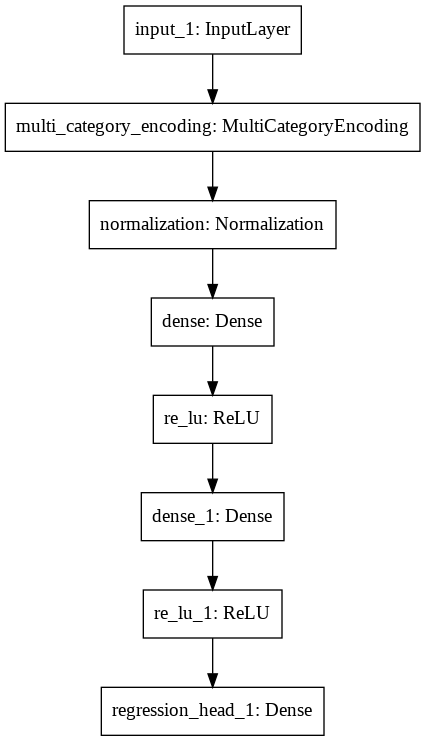

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 27)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 27)                0         
_________________________________________________________________
normalization (Normalization (None, 27)                55        
_________________________________________________________________
dense (Dense)                (None, 32)                896       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)               

None

In [8]:
def display_best_model(ak_model):
    '''ベストなモデルの構造を表示'''
    best_model = ak_model.export_model()
    display(plot_model(best_model))
    display(best_model.summary())


display_best_model(ak_model=regressor)

## モデルの評価

In [9]:
def take_best_model(ak_model):
    '''ベストなモデルを取り出し'''
    best_model = ak_model.export_model()
    return best_model


model = take_best_model(ak_model=regressor)

### Kerasの組み込み評価関数

In [10]:
%%time
score = model.evaluate(x=X_test.values.astype('unicode'), y=y_test.values, batch_size=256)
display('loss : {}, accuracy : {}'.format(score[0], score[1]))

10/10 [==============================] - 0s 4ms/step - loss: 75.4418 - mean_squared_error: 75.4418


'loss : 75.4417724609375, accuracy : 75.4417724609375'

CPU times: user 302 ms, sys: 16.2 ms, total: 318 ms
Wall time: 305 ms


### sklearnの評価関数

In [11]:
%%time
def _calc_score(y_true, y_pred, sklearn_metric):
  '''sklearnの評価指標のスコアを計算'''
  score = sklearn_metric(y_true=y_true, y_pred=y_pred)
  return score


def evaluete_sk_metrics(y_true, y_pred, sklearn_metrics):
  '''sklearnの各種、評価関数を使用'''
  result = {}
  for sk_metric in sklearn_metrics:
    result[sk_metric.__name__] = _calc_score(y_true=y_true, y_pred=y_pred, sklearn_metric=sk_metric)
  return result


SK_METRICS=[r2_score, explained_variance_score, mean_squared_error]
eval_scores = {'train': {}, 'test': {}}

for key, X, y_true in zip(['train', 'test'], [X_train, X_test], [y_train, y_test]):
  y_pred = model.predict(X.values.astype('unicode'))
  eval_scores[key] = evaluete_sk_metrics(y_true=y_true, y_pred=y_pred, sklearn_metrics=SK_METRICS)
pprint.pprint(eval_scores)

{'test': {'explained_variance_score': 0.0,
          'mean_squared_error': 75.44177,
          'r2_score': -0.07528751018156887},
 'train': {'explained_variance_score': 0.0,
           'mean_squared_error': 98.950066,
           'r2_score': -0.06319235821005709}}
CPU times: user 1.78 s, sys: 149 ms, total: 1.93 s
Wall time: 1.3 s
